# UNet для семантической сегментации

В этом ноутбуке мы реализуем архитектуру UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 11 классов дорожных сцен.


In [2]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None, img_size=(256, 256)):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        
        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []
        
        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]
                        
                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)
                        
                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)
                        
                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))
        
        print("Loaded {} samples from {} split".format(len(self.samples), split))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        
        image = Image.open(img_path).convert('RGB')
        image = image.resize(self.img_size, Image.BILINEAR)
        
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(self.img_size, Image.NEAREST)
        
        image = np.array(image).astype(np.float32) / 255.0
        mask = np.array(mask).astype(np.int64)
        
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask


## Архитектура UNet

Реализуем архитектуру UNet с энкодером-декодером и skip connections.


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели сегментации.


In [4]:
class SegmentationModule(pl.LightningModule):
    def __init__(self, n_channels=3, n_classes=12, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = UNet(n_channels=n_channels, n_classes=n_classes)
        self.learning_rate = learning_rate
        self.n_classes = n_classes
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self.forward(images)
        
        loss = F.cross_entropy(logits, masks)
        
        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self.forward(images)
        
        loss = F.cross_entropy(logits, masks)
        
        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        images, masks = batch
        logits = self.forward(images)
        
        loss = F.cross_entropy(logits, masks)
        
        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def compute_iou(self, preds, targets):
        ious = []
        for cls in range(self.n_classes):
            pred_cls = (preds == cls)
            target_cls = (targets == cls)
            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.mean())
        return torch.stack(ious).mean()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }


## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [5]:
data_dir = '../data'

train_dataset = CamVidDataset(
    data_dir=data_dir,
    split='train',
    img_size=(256, 256)
)

val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    img_size=(256, 256)
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 16
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)




Loaded 367 samples from train split
Loaded 101 samples from val split
Train samples: 367
Val samples: 101


## Визуализация данных

Проверяем загрузку данных и визуализируем примеры изображений и масок.


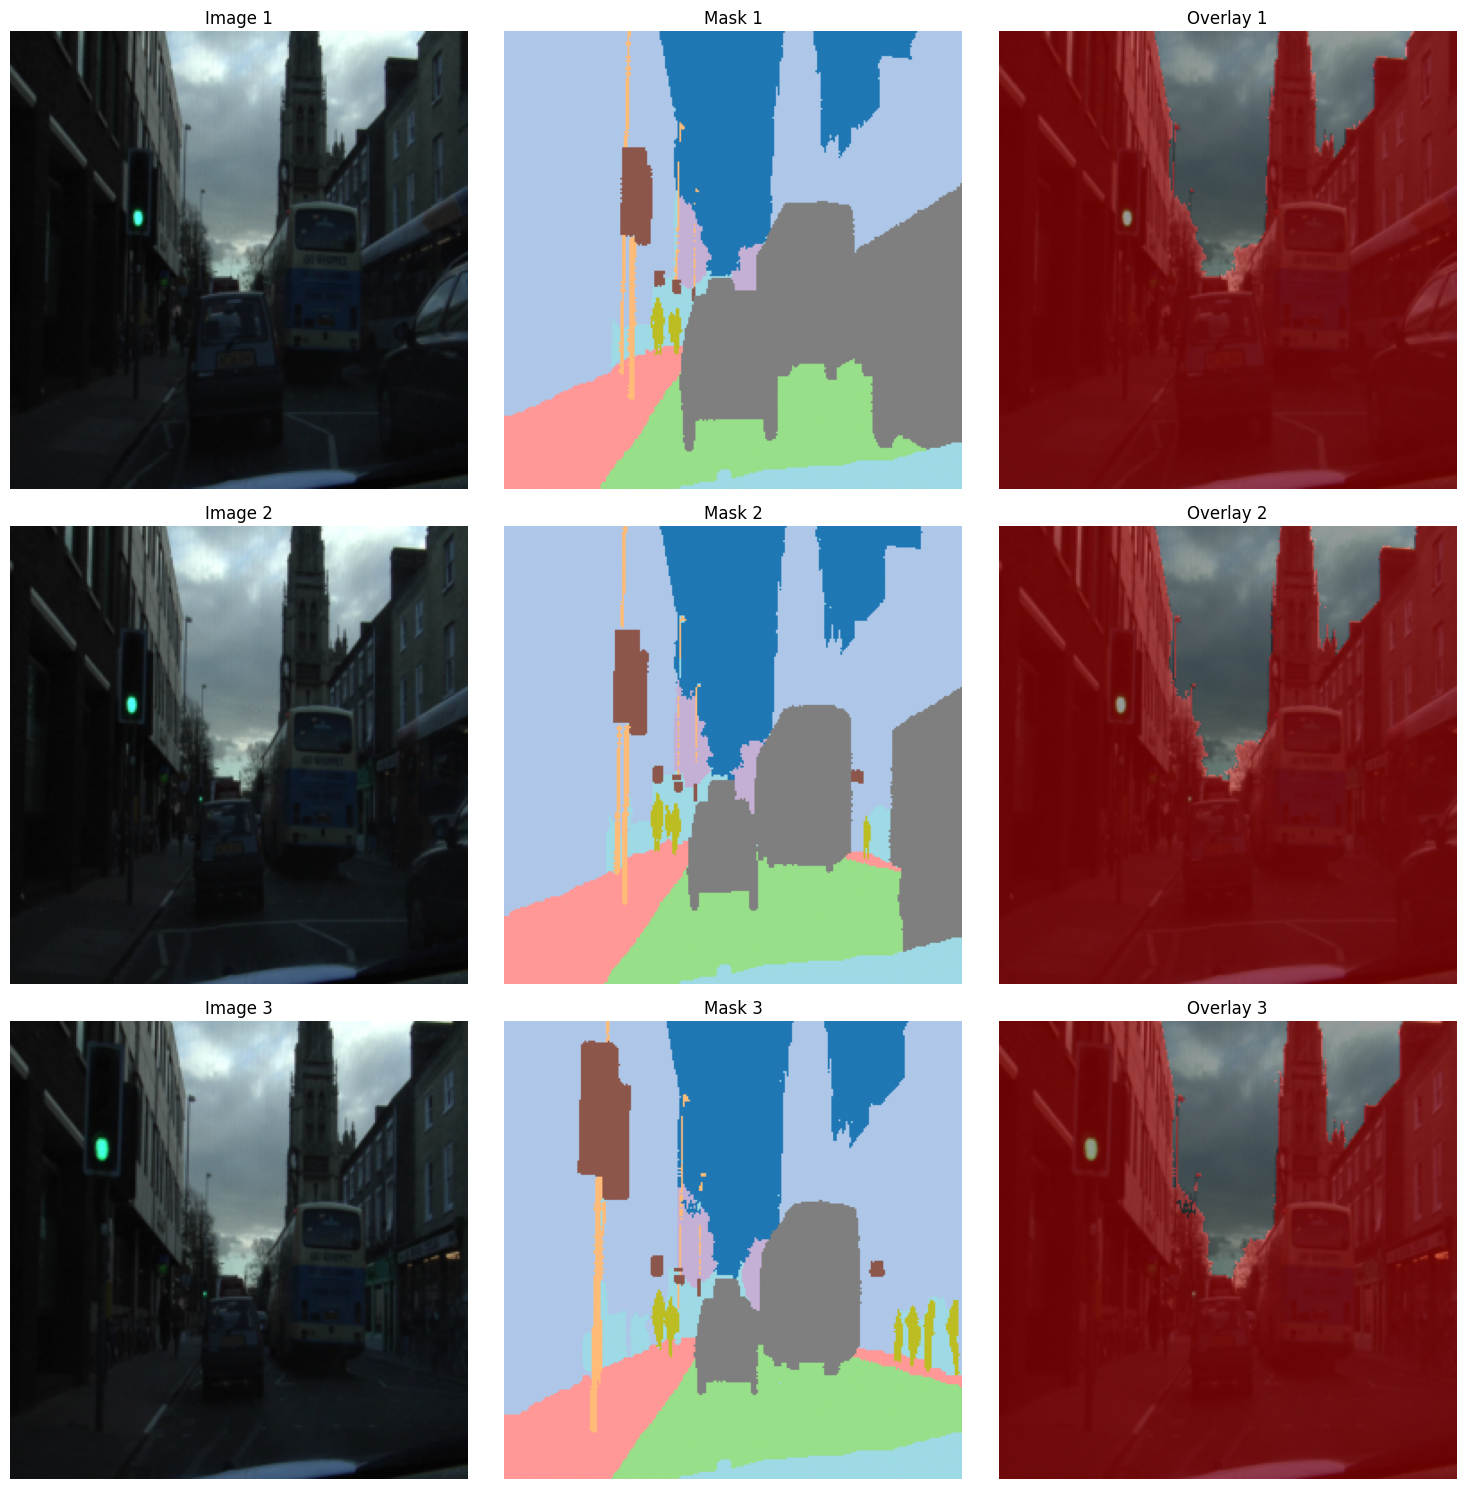

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11])


In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    image, mask = train_dataset[i]
    
    img_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')
    
    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")


## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [7]:
model = SegmentationModule(
    n_channels=3,
    n_classes=12,
    learning_rate=1e-4
)

sample_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    sample_output = model(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 12, 256, 256])
Model parameters: 17,268,108


## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [8]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    filename='unet-{epoch:02d}-{val_iou:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_iou',
    mode='max',
    patience=10,
    verbose=True
)

logger = TensorBoardLogger('lightning_logs', name='unet_segmentation')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10,
    val_check_interval=0.5
)

trainer.fit(model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 17.3 M | train
---------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.072    Total estimated model params size (M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved. New best score: 0.089


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.012 >= min_delta = 0.0. New best score: 0.101


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.095 >= min_delta = 0.0. New best score: 0.197


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.075 >= min_delta = 0.0. New best score: 0.272


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.081 >= min_delta = 0.0. New best score: 0.353


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.020 >= min_delta = 0.0. New best score: 0.373


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.379


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.395


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.404


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.404


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.409


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.028 >= min_delta = 0.0. New best score: 0.437


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.442


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.452


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.460


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.460


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.033 >= min_delta = 0.0. New best score: 0.493


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.496


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.498


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.500


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.510


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.528


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.533


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_iou improved by 0.021 >= min_delta = 0.0. New best score: 0.554


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_iou did not improve in the last 10 records. Best score: 0.554. Signaling Trainer to stop.


## Оценка на тестовом датасете

Оцениваем качество модели на тестовом датасете.


In [9]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs/unet_segmentation/version_0/checkpoints/unet-epoch=32-val_iou=0.5539.ckpt


## Визуализация результатов

Визуализируем предсказания модели на нескольких примерах из тестового датасета.


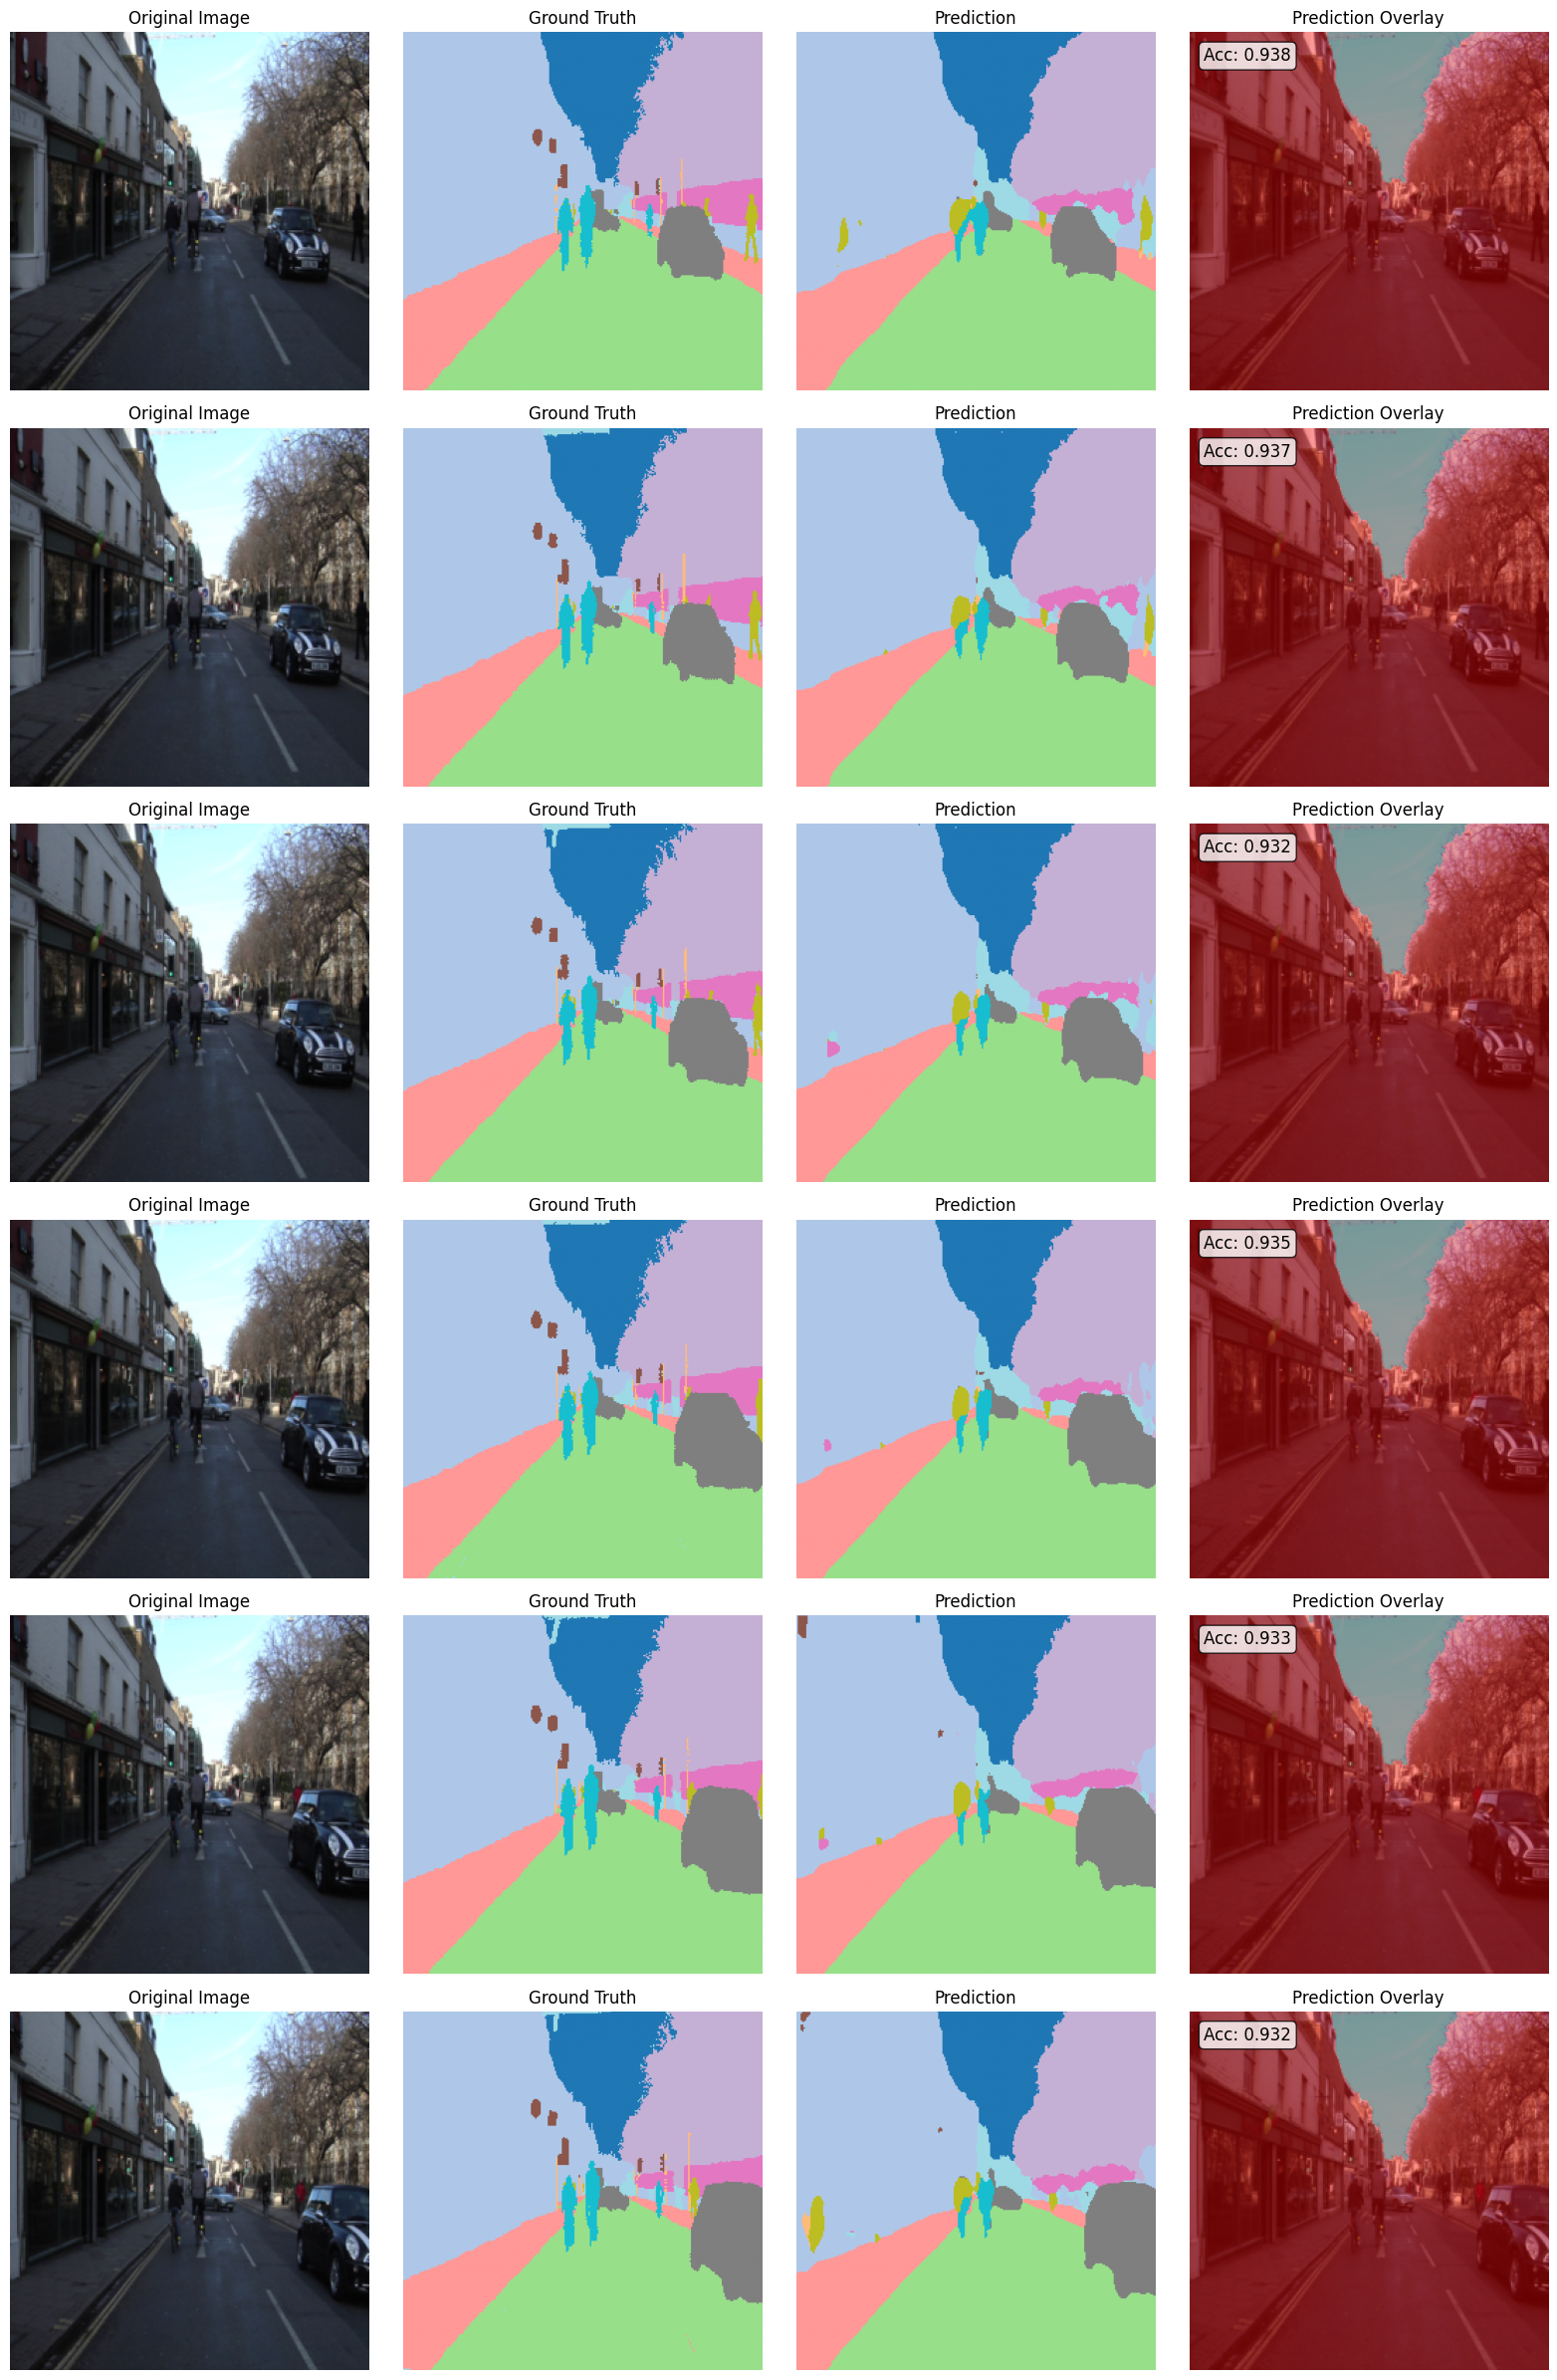

In [10]:
model.eval()
device = next(model.parameters()).device

num_samples = 6
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        logits = model(image_batch)
        pred = torch.argmax(logits, dim=1).cpu().squeeze()
        
        img_np = image.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()
        pred_np = pred.numpy()
        
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')
        
        overlay = img_np.copy()
        pred_colored = np.zeros_like(img_np)
        pred_colored[pred_np > 0] = [1, 0, 0]
        overlay = overlay * 0.6 + pred_colored * 0.4
        
        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Prediction Overlay')
        axes[idx, 3].axis('off')
        
        correct = (pred_np == mask_np).sum()
        total = mask_np.size
        pixel_acc = correct / total
        axes[idx, 3].text(10, 20, f'Acc: {pixel_acc:.3f}', 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Метрики на тестовом датасете

Вычисляем детальные метрики на тестовом датасете.


In [11]:
def compute_metrics(preds, targets, n_classes=12):
    ious = []
    for cls in range(n_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).float().sum((1, 2))
        union = (pred_cls | target_cls).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.mean().item())
    
    mean_iou = np.mean(ious)
    
    correct = (preds == targets).float().sum((1, 2))
    total = targets.numel() // targets.shape[0]
    pixel_acc = correct.sum().item() / (targets.shape[0] * total)
    
    return {
        'mean_iou': mean_iou,
        'iou_per_class': ious,
        'pixel_acc': pixel_acc
    }

model.eval()
all_preds = []
all_targets = []

val_loader_eval = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

with torch.no_grad():
    for images, masks in tqdm(val_loader_eval, desc="Evaluating"):
        images = images.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.append(preds)
        all_targets.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

metrics = compute_metrics(all_preds, all_targets, n_classes=12)

camvid_classes = ['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Void']

print("="*60)
print("Validation Metrics:")
print("="*60)
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_acc']:.4f}")
print("\nIoU per class:")
for cls_name, iou in zip(camvid_classes, metrics['iou_per_class']):
    print(f"  {cls_name}: {iou:.4f}")
print("="*60)


Evaluating: 100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


Validation Metrics:
Mean IoU: 0.5366
Pixel Accuracy: 0.8991

IoU per class:
  Sky: 0.9415
  Building: 0.7995
  Column-Pole: 0.0019
  Road: 0.9595
  Sidewalk: 0.8423
  Tree: 0.8756
  Sign-Symbol: 0.1171
  Fence: 0.5220
  Car: 0.5350
  Pedestrian: 0.2450
  Bicyclist: 0.4166
  Void: 0.1836
